In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_rows',1000)
import os
from glob import iglob

In [18]:
# Load all structural p-values across both analyses
df = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-05-06/clinvar/pathogenic_K_summary.txt",delimiter='\t')

In [19]:
print "Number of structures evaluated:"
print len(df)
print "Number of variants evluated:"
print "%.0f"%np.sum(df["N"])
print "Mean and Std K:"
print "%.2f"%np.mean(df["Kz"])
print "%.2f"%np.std(df["Kz"])

from qvalue import estimate
THRESH = 0.1

df.ix[~df[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(df.ix[~df[ "Kp"].isnull(), "Kp"].values)

print "\nProteins passing an FDR of %.0f%% for the unweighted analysis"%(THRESH*100)
print "Significant:   %4d"%( df['Kq']<THRESH).sum()
print "    Clustered: %4d"%((df['Kq']<THRESH) & (df["Kz"]>0)).sum()
print "    Dispersed: %4d"%((df['Kq']<THRESH) & (df["Kz"]<0)).sum()

Number of structures evaluated:
453
Number of variants evluated:
4827
Mean and Std K:
1.51
2.16

Proteins passing an FDR of 10% for the unweighted analysis
Significant:     88
    Clustered:   88
    Dispersed:    0


In [20]:
df.to_csv("/Volumes/sivleyrm/pdbmap/results/ripleysK_results/pdb_clinvar_missense_univariate.txt",
            header=False,index=False,sep="\t",na_rep="\N")

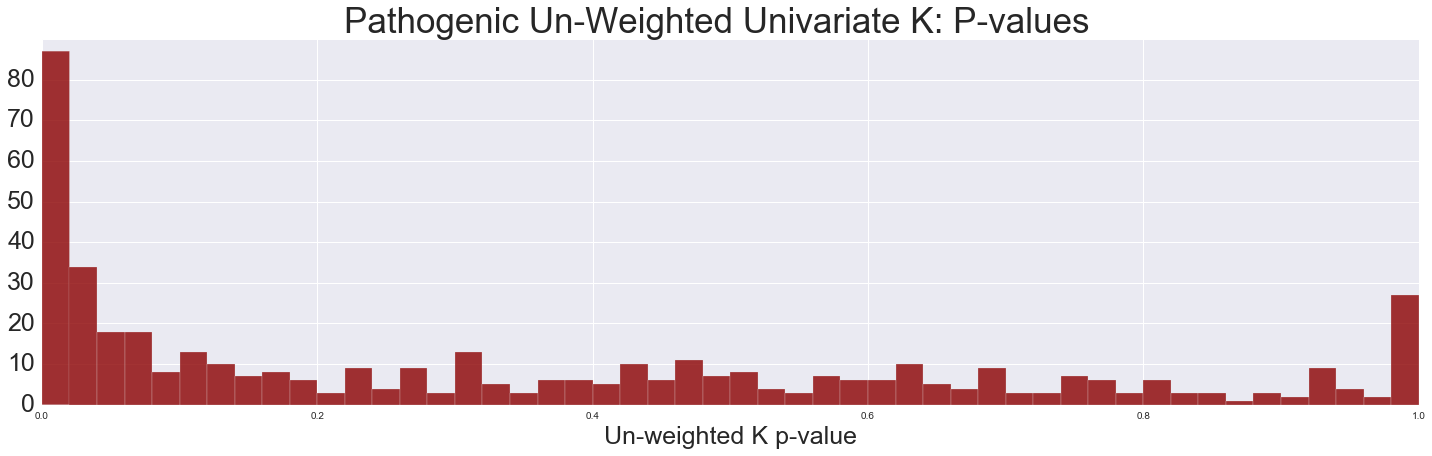

In [21]:
# P-Value Distributions
fig,ax = plt.subplots(1,1,figsize=(20,6))
plt.suptitle("Pathogenic Un-Weighted Univariate K: P-values",fontsize=35,y=1.05)
ax.set_xlabel("Un-weighted K p-value",fontsize=25)
# ax[0].hist(df["Kzp"],bins=np.arange(0,1.02,0.02),color="darkblue",normed=True)
ax.hist(df["Kp"],bins=np.arange(0,1.02,0.02),color="darkred",alpha=0.8)
# ax.plot(K_lam,K_pi,lw=3,c='cornflowerblue')
ax.set_yticklabels(range(0,90,10),fontsize=25)
plt.tight_layout()
plt.show()

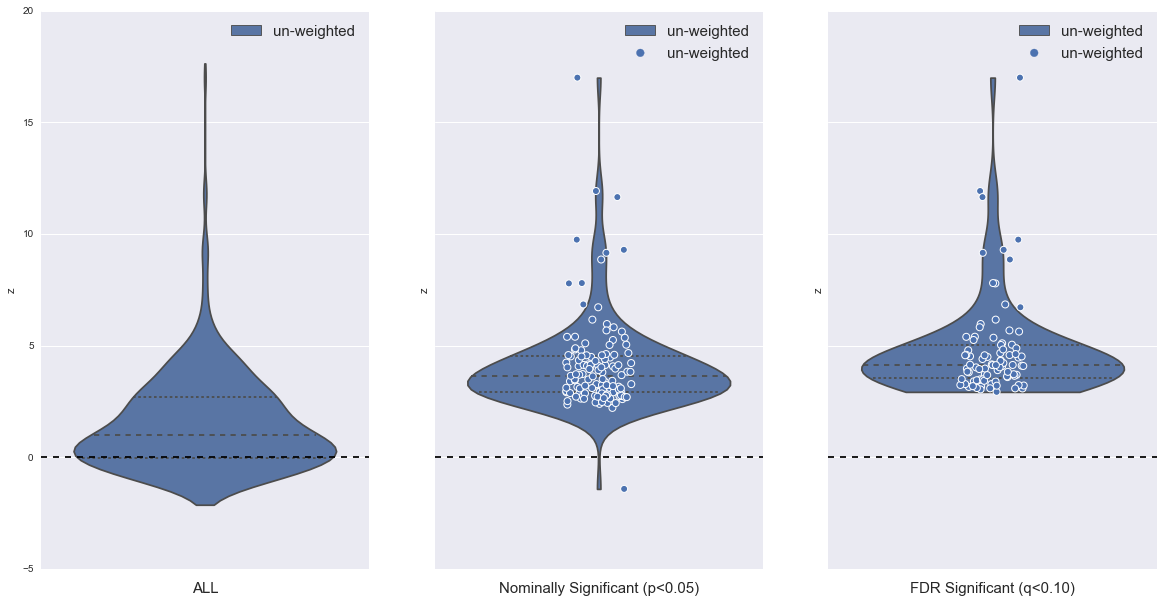

In [22]:
dfv = pd.DataFrame(df[["Kp","Kz"]].values,columns=["p","z"])
dfv['q'] = estimate(dfv["p"].values)[0]
dfv["w"] = "un-weighted"
dfv['dummy'] = ""

fig,ax = plt.subplots(1,3,figsize=(20,10),sharey=True)
sns.violinplot(x='dummy',y="z",hue='w',data=dfv,ax=ax[0],cut=1,orient='v',inner='quart')
dfv1 = dfv[dfv["p"]<0.05]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=split,cut=0,inner='quart')
    sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=True,jitter=True,s=7,lw=1,edgecolor='white')
dfv1 = dfv[dfv["q"]<THRESH]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=split,cut=0,inner='quart')
    sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=True,jitter=True,s=7,lw=1,edgecolor='white')
ax[0].set_xlabel("ALL",fontsize=15)
ax[1].set_xlabel("Nominally Significant (p<0.05)",fontsize=15)
ax[2].set_xlabel("FDR Significant (q<%.2f)"%THRESH,fontsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
plt.ylim([-5,20])
ax[0].axhline(0.,ls='dashed',c='black')
ax[1].axhline(0.,ls='dashed',c='black')
ax[2].axhline(0.,ls='dashed',c='black')
plt.show()

In [23]:
print "Un-Weighted: FDR-Significant Proteins"
print df.ix[df["Kq"]<0.1,["structid","chain","Kz","Kp","Kq"]]

Un-Weighted: FDR-Significant Proteins
    structid chain         Kz       Kp        Kq
4       3EQ1     B   4.238356  0.00184  0.022208
5       3RBN     B   3.274026  0.01040  0.061481
10      1XDV     B   3.589189  0.00744  0.052003
12      3F5N     D   3.804580  0.01120  0.062765
15      1NQ0     A   5.397400  0.00012  0.003506
17      3BIC     B   3.485785  0.00778  0.053045
18      1OWA     A   3.399793  0.01318  0.069126
26      4IJQ     C   3.080289  0.01234  0.068182
27      4ATU     I   4.665535  0.00030  0.007219
37      3II5     A  11.925795  0.00002  0.001023
38      4L3V     B   3.159947  0.01268  0.068254
39      2WPL     S   4.076080  0.00234  0.025191
44      2K27     A   4.518484  0.00446  0.038011
47      1G88     A   4.340979  0.00140  0.019091
52      4AW6     E   4.132788  0.01086  0.061705
64      1SIQ     A   2.927672  0.01672  0.080567
74      2AMY     A   3.389400  0.00692  0.049665
76      3GRO     A   4.100590  0.00276  0.028227
79      4BGQ     A   5.628436  

In [24]:
# Examine how many COSMIC-significant proteins contain 3+ ClinVar nsSNVs
# In how many of those proteins were ClinVar nsSNVs also significantly clustered?
# These are generated from the end of the univariate COSMIC notebook
csm_sig = ['2SHP', '2OVQ', '4NM6', '4BHW', '1D5R', '4JSP', '2WTK', '2RD0', '1RJB', '3IJ9', '3GT8', '2K60', '2Q7Z', '2Y1M', '1MFV']
ovlp = df[df['structid'].isin(csm_sig)]
print len(csm_sig)-len(ovlp),'of',len(csm_sig),'COSMIC-significant proteins do not contain 3+ ClinVar nsSNVs'
print '\n',ovlp[["structid","chain","R","N","Kz","Kq"]]
print '\n',(ovlp["Kq"]<0.1).sum(),'of',len(ovlp),'of the overlapping proteins are FDR-significant in ClinVar'
print '\n',ovlp.ix[ovlp["Kq"]<0.1,["structid","chain","R","N","Kz","Kq"]]

9 of 15 COSMIC-significant proteins do not contain 3+ ClinVar nsSNVs

    structid chain    R     N         Kz        Kq
112     1D5R     A  307  41.0   8.857042  0.001023
114     2SHP     B  491  44.0  17.005326  0.001023
186     2Y1M     F  384   9.0   7.801796  0.002727
256     2RD0     A  984   8.0   2.766081  0.117197
376     2K60     A  144   5.0   4.143031  0.046158
411     2WTK     C  285  14.0   4.575626  0.020710

5 of 6 of the overlapping proteins are FDR-significant in ClinVar

    structid chain    R     N         Kz        Kq
112     1D5R     A  307  41.0   8.857042  0.001023
114     2SHP     B  491  44.0  17.005326  0.001023
186     2Y1M     F  384   9.0   7.801796  0.002727
376     2K60     A  144   5.0   4.143031  0.046158
411     2WTK     C  285  14.0   4.575626  0.020710
